One technique/tool for address unbalanced data is SMOTE.  I've added the original SMOTE paper to the module page (thanks to Esther for digging it out).  I've also linked to the libraries associated with this (contains a whole suite of techniques for unbalanced data).

https://moodle.city.ac.uk/pluginfile.php/2571477/mod_resource/content/1/SMOTE.pdf

https://imbalanced-learn.org/stable/references/index.html



**Plan**: we need to understand correlations:
- **1** 'Severity of Illness' at 'Type of Admission' on 'Stay', those with higher - longer
- **2** if high, then less 'Visitors with Patient'  but long 'Stay'
- **3** prior knowledge of LOS can aid in logistics such as room and bed allocation planning= all high risk together

## Content:
- [Part 1](#part1)- Importing the data set
- [Part 2](#part2)- Exploratory data analysis
- [Part 3](#part3) -  Preparing our data
- [Part 4](#part4) -  Correlation
- [Part 5](#part5) -  Splitting our data for modelling
- [Part 6](#part6) -  Decision tree model (reservation_status included)
- [Part 7](#part7) -  Random Forest
- [Part 8](#part8) -  Naïve Bayes
- [Part 9](#part9) -  Gradient Boost Classifier
- [Part 10](#part10) -  CatBoost Classifier
    
P.S. The length of stay - 11 different classes ranging from 0-10 days to more than 100 days.

**Here's a description of what some of the features in the dataframe above represent:**

- `Column`	Description
- `case_id`	Case_ID registered in Hospital
- `Hospital_code`	Unique code for the Hospital
- `Hospital_type_code`	Unique code for the type of Hospital
- `City_Code_Hospital` City Code of the Hospital
- `Hospital_region_code`	Region Code of the Hospital
- `Available Extra Rooms in Hospital`	Number of Extra rooms available in the Hospital
- `Department`	Department overlooking the case
- `Ward_Type`	Code for the Ward type
- `Ward_Facility_Code`	Code for the Ward Facility
- `Bed Grade`	Condition of Bed in the Ward
- `patientid`	Unique Patient Id
- `City_Code_Patient`	City Code for the patient
- `Type of Admission`	Admission Type registered by the Hospital
- `Severity of Illness`	Severity of the illness recorded at the time of admission
- `Visitors with Patient`	Number of Visitors with the patient
- `Age`	Age of the patient
- `Admission_Deposit`	Deposit at the Admission Time
- `Stay`	Stay Days by the patient


[Back to top](#Content:)


<a id='part1'></a>

### Part 1 -  Importing the data set

In [1]:
import os
# import sys
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
%matplotlib inline

# import tensorflow as tf
# from tensorflow import keras


# Metric for classification 

Score of 1 is perfect.
The closer the score to 1 the better


In [2]:
K = 10 # Num of Classes - 1 here

# Classes can be ranked here from 0-10
def score(pred, target):
    error = np.mean(np.abs(pred-target))/K
    score = 1 - error
    return score

In [2]:
path = "healthcare"

filename_read = os.path.join(path, "train_data.csv")
df = pd.read_csv(filename_read, na_values=['NA', '?'])

# print(df[0:5])
print(df.shape)
print(df.columns)

(318438, 18)
Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')


In [3]:
## loading the file
health_care = pd.read_csv('./healthcare/train_data.csv')

In [4]:
df.head(10)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
5,6,23,a,6,X,2,anesthesia,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,4449.0,11-20
6,7,32,f,9,Y,1,radiotherapy,S,B,3.0,31397,7.0,Emergency,Extreme,2,51-60,6167.0,0-10
7,8,23,a,6,X,4,radiotherapy,Q,F,3.0,31397,7.0,Trauma,Extreme,2,51-60,5571.0,41-50
8,9,1,d,10,Y,2,gynecology,R,B,4.0,31397,7.0,Trauma,Extreme,2,51-60,7223.0,51-60
9,10,10,e,1,X,2,gynecology,S,E,3.0,31397,7.0,Trauma,Extreme,2,51-60,6056.0,31-40


[Back to top](#Content:)

<a id='part2'></a>
### Part 2- Exploratory data analysis (EDA)

In [5]:
#creating a copy of df to have an original for further manipulation
new_df = df.copy()
new_df = new_df.select_dtypes(include=["int","float"])

headers = list(new_df.columns.values)

## For this part you should drop  :
- Case_id
- Hospital_code
- patientid
- City_Code_Patient

There mean/std is not relevant

In [6]:
fields = []
for field in headers:
    fields.append({
        "name":field,
        "mean":df[field].mean(),
        "var":df[field].var(),
        "sdev":df[field].std()
    })
for field in fields:
    print(field)

{'name': 'case_id', 'mean': 159219.5, 'var': 8450256523.484579, 'sdev': 91925.27684747313}
{'name': 'Hospital_code', 'mean': 18.318840716246175, 'var': 74.54172342795314, 'sdev': 8.633754885792921}
{'name': 'City_Code_Hospital', 'mean': 4.771716943329627, 'var': 9.62572562697152, 'sdev': 3.102535354669068}
{'name': 'Available Extra Rooms in Hospital', 'mean': 3.1976271676119055, 'var': 1.364624484865746, 'sdev': 1.1681714278588335}
{'name': 'Bed Grade', 'mean': 2.625806958297338, 'var': 0.7623835960741749, 'sdev': 0.873145804590605}
{'name': 'patientid', 'mean': 65747.57947229916, 'var': 1442475571.9882374, 'sdev': 37979.93644002367}
{'name': 'City_Code_Patient', 'mean': 7.251858836721821, 'var': 22.517545245763493, 'sdev': 4.745265561142337}
{'name': 'Visitors with Patient', 'mean': 3.2840992595104854, 'var': 3.1119125861261314, 'sdev': 1.7640613895571013}
{'name': 'Admission_Deposit', 'mean': 4880.749392346391, 'var': 1181082.625479292, 'sdev': 1086.7762536416094}


#????**here should an analysis of columns means and st dev**

Missing Values

In [7]:
#checking for missing values
df.isnull().values.any()

True

In [8]:
#Checking number of NANs for each column, in order to understand how many missing values there are in a dataframe.
print("# of NaN in each columns:", df.isnull().sum(), sep='\n')

# of NaN in each columns:
case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64


## NA values :

Represent 1.45% for the data set, i think either drop it or check later if City_Code_Patient is actually a relevant covariant, if not drop it and keep the rest of data

## Feature engineering

We will add 2 features : 
- Visit number
- New Patient

In [4]:
n = health_care.shape[0]
visits = []
patientid = np.array(health_care['patientid'])
for i in range(n) :
    count = (patientid[:i+1] == patientid[i]).sum()
    visits.append(count)
    
health_care['Visit Number'] = visits
health_care['New Patient'] = (health_care['Visit Number']==1).astype('int32')

To make sure we consider all the correct features to make an accurate prediction, it may be useful to create some plots to have a better understanding of our data.

we will be using the Python data visualisation library seaborn. 

We could begin by visualising the length of stays by type of admissions etc., by using a countplot(), that shows the counts of observations in each categorical bin using bars.

In [10]:
#sorting by Stay for better representation in the visualisations
df= df.sort_values(by = "Stay", ascending = True)
df.head(10)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
136814,136815,28,b,11,X,2,gynecology,R,F,3.0,112307,1.0,Emergency,Moderate,2,21-30,4517.0,0-10
136815,136816,29,a,4,X,3,gynecology,S,F,3.0,112307,1.0,Emergency,Moderate,2,21-30,3846.0,0-10
136823,136824,11,b,2,Y,4,gynecology,Q,D,4.0,64198,14.0,Emergency,Moderate,2,21-30,5183.0,0-10
136837,136838,14,a,1,X,3,gynecology,R,E,3.0,76865,1.0,Emergency,Extreme,3,51-60,3452.0,0-10
136845,136846,1,d,10,Y,3,radiotherapy,S,B,4.0,19181,7.0,Emergency,Minor,2,51-60,3908.0,0-10
136846,136847,1,d,10,Y,2,radiotherapy,S,B,4.0,19181,7.0,Emergency,Minor,2,51-60,3934.0,0-10
136847,136848,12,a,9,Y,5,gynecology,Q,B,1.0,19181,7.0,Urgent,Moderate,4,51-60,3410.0,0-10
136866,136867,14,a,1,X,2,gynecology,R,E,3.0,101538,8.0,Emergency,Moderate,3,51-60,4222.0,0-10
136874,136875,6,a,6,X,2,gynecology,Q,F,3.0,40220,8.0,Emergency,Moderate,4,71-80,5746.0,0-10


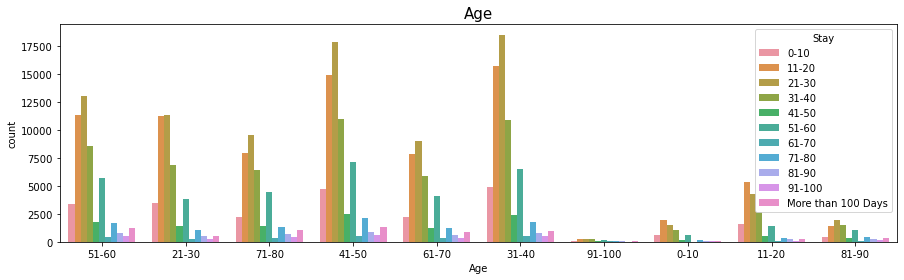

In [11]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Age", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Age", hue = 'Stay', data = df)

In [12]:
#?? comments
#the age group risk - 21-80y.o.

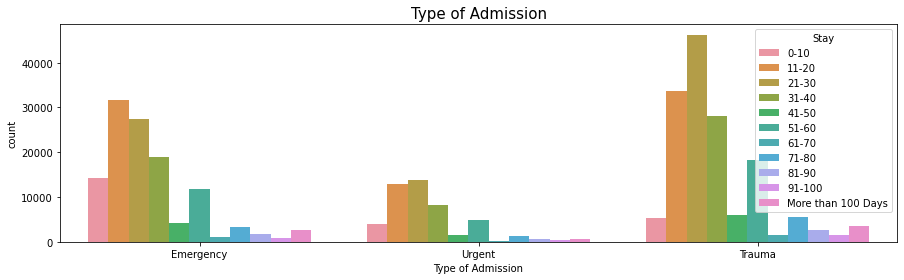

In [13]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Type of Admission", fontdict = {'fontsize': 15})
ax = sns.countplot(x = "Type of Admission", hue = 'Stay', data = df)


???? comments on the graph


Emergency and Trauma and mostly from 11 - 40  and range 51-60 


Next, it may be interesting to look at the Severity of Illness segments by stay.

Again, we can use a count plot to visualise this.

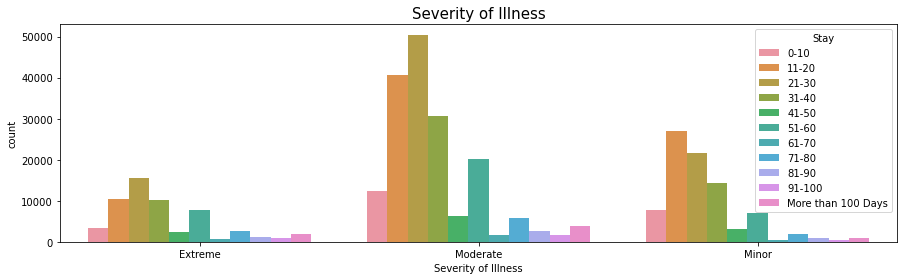

In [14]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Severity of Illness", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Severity of Illness", hue = 'Stay', data = df)

???? comments on the graph: 


mostly moderate and minor, and in age range 11-40  and range 51-60 


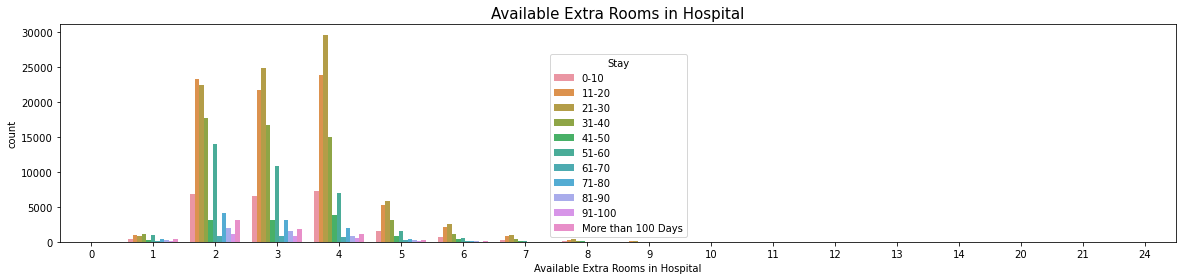

In [15]:
#plot size
plt.figure(figsize = (20,4))
#plot title
plt.title("Available Extra Rooms in Hospital", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Available Extra Rooms in Hospital", hue = 'Stay', data = df)

???? comments on the graph

most rooms have additional 2-4 beds in the room available.

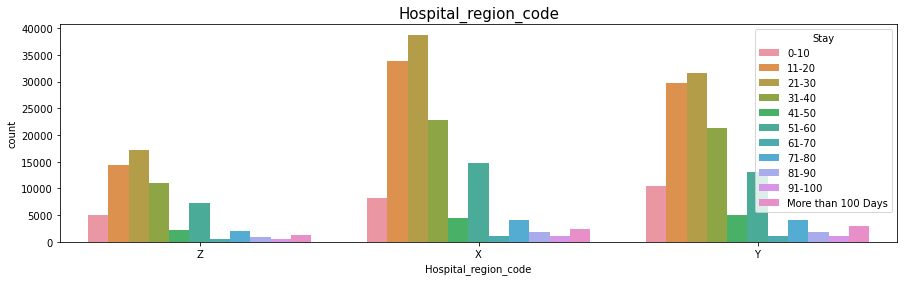

In [16]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Hospital_region_code", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Hospital_region_code", hue = 'Stay', data = df)

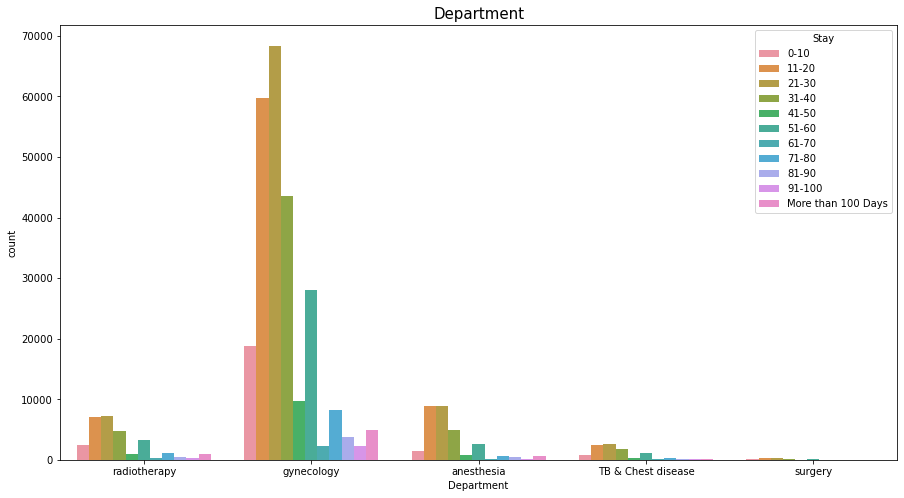

In [17]:
#plot size
plt.figure(figsize = (15,8))
#plot title
plt.title("Department", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Department", hue = 'Stay', data = df)

In [18]:
#??? commments
#mostly gynecology department

# Data Analysis Part - Baraa

In [19]:
## Checking target
target = health_care['Stay']

In [20]:
## Encoding data
encoder = LabelEncoder()
target_enc = encoder.fit_transform(target)

### Checkin for number of unique element for each feature

In [21]:
for column in health_care.columns :
    x = pd.unique(health_care[column])
    print(f'number of unique elements of  {column} is : {len(x)}')

number of unique elements of  case_id is : 318438
number of unique elements of  Hospital_code is : 32
number of unique elements of  Hospital_type_code is : 7
number of unique elements of  City_Code_Hospital is : 11
number of unique elements of  Hospital_region_code is : 3
number of unique elements of  Available Extra Rooms in Hospital is : 18
number of unique elements of  Department is : 5
number of unique elements of  Ward_Type is : 6
number of unique elements of  Ward_Facility_Code is : 6
number of unique elements of  Bed Grade is : 5
number of unique elements of  patientid is : 92017
number of unique elements of  City_Code_Patient is : 38
number of unique elements of  Type of Admission is : 3
number of unique elements of  Severity of Illness is : 3
number of unique elements of  Visitors with Patient is : 28
number of unique elements of  Age is : 10
number of unique elements of  Admission_Deposit is : 7300
number of unique elements of  Stay is : 11
number of unique elements of  Visit

## Visualisation of Target categories

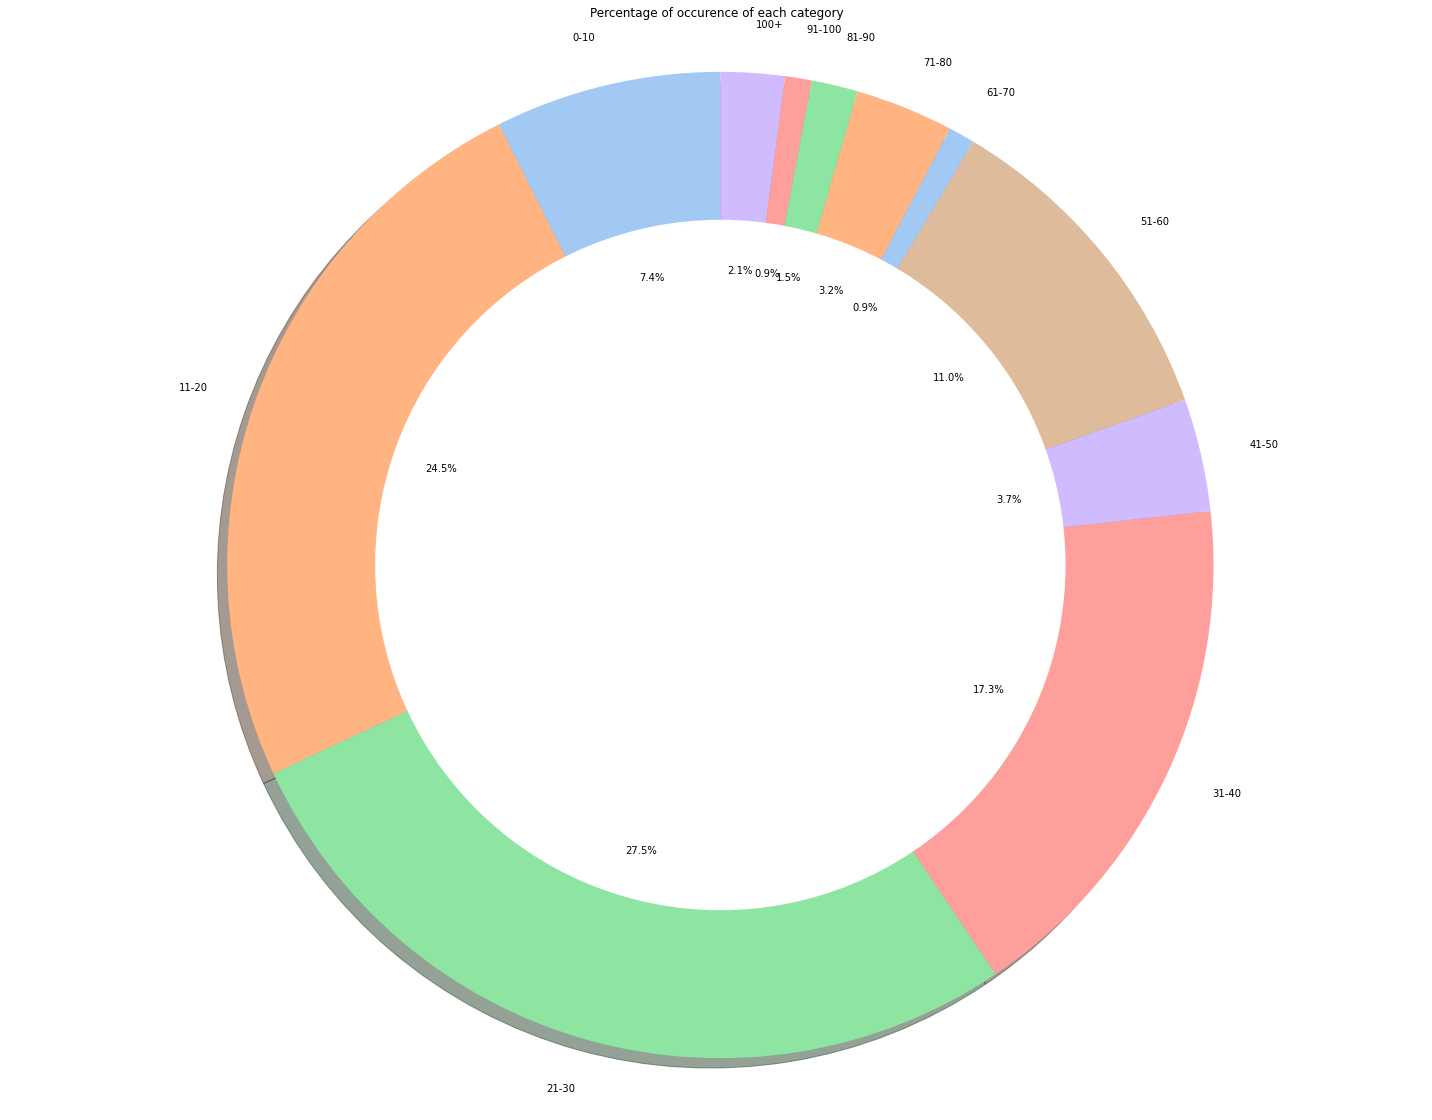

In [22]:
fig, ax1 = plt.subplots()
labels = np.unique(health_care['Stay'])
labels[-1] = '100+'

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:6]
plt.pie(health_care.groupby('Stay').size(), labels = labels,colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
fig.set_size_inches(20, 15.5)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Percentage of occurence of each category')
plt.show()

## Remark

Data shows an unusual distribution of the length of stay categories, especially we see that the 51-60 category is abnormally higher than what we could expect.

McClean and Millard (1993) have established that lognormal and exponential mixture distributions might be a better description for the LOS dataset. Marazzi et al. (1998) established to check the adequacy of lognormal (long tailed), Weibull and gammamodels (short tailed) to study LOS and concluded that Weibull and gamma behaved similarly in nature. Clark and Ryan (2002) and Clark et al. (2007) considered piecewise exponential models for predicting mortality, hospital LOS, and long-term care for trauma patients. Gardiner (2014) considered Coxian phase-type models, mixtures of exponential distributions, and other heavy-tailed distributions such as Weibull, Pareto, generalized Pareto, lognormal for modeling LOS by parametric and Bayesian approaches. The modeling of LOS with the help of convolutive mixture distribution for studying the short and long stay of patients in the hospital is studied by Ickowicz and Sparks (2016).

## Histogram plot 


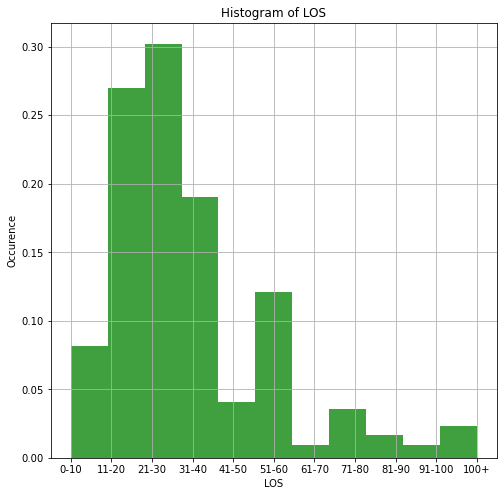

In [23]:
h = health_care['Stay'].sort_values()
h[h=='More than 100 Days'] = '100+'
plt.figure(figsize = (8,8))
plt.hist(h, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)



plt.xlabel('LOS')
plt.ylabel('Occurence')
plt.title('Histogram of LOS')


plt.grid(True)
plt.show()

The percentage of patient staying more than 60 days is 8.55%

In [24]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
health_care['Stay_cat'] = encoder.fit_transform(health_care['Stay'])
n = len(health_care['Stay_cat'])
l = []
for i in range(len(np.unique(health_care['Stay_cat']))):
    k = len(health_care[health_care['Stay_cat']==i])
    #print(f'N {10*i} and {10*(i+1)} is : {k}')
    print(f'{i}- {k}  : {100*k/n:.2f}%')
   
    
    
    
    

0- 23604  : 7.41%
1- 78139  : 24.54%
2- 87491  : 27.48%
3- 55159  : 17.32%
4- 11743  : 3.69%
5- 35018  : 11.00%
6- 2744  : 0.86%
7- 10254  : 3.22%
8- 4838  : 1.52%
9- 2765  : 0.87%
10- 6683  : 2.10%


In [25]:
## functions to feed to barplot
def mean(x):
    return np.mean(x)

def median(x):
    return np.median(x)

def std(x):
    return np.std(x)


In [26]:
## Estimate of length of stay
target_estimate = 10* (target_enc) + 5
# Adding the estimate to the dataframe
health_care['Stay Estimate'] = target_estimate


In [27]:
## Using only Features with limited classes for the plot
elements_to_remove = ['case_id', 'patientid', 'Admission_Deposit', 'Stay', 'Stay Estimate']
column_features = [ column for column in health_care.columns if column not in elements_to_remove]
print(column_features)

['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available Extra Rooms in Hospital', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age', 'Visit Number', 'New Patient', 'Stay_cat']


## Mean Analysis

We study the relationship between the mean of stay and each feature

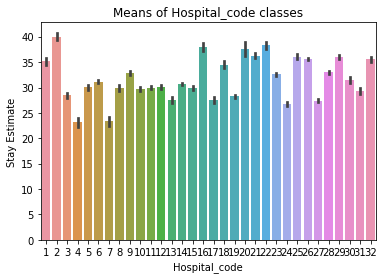

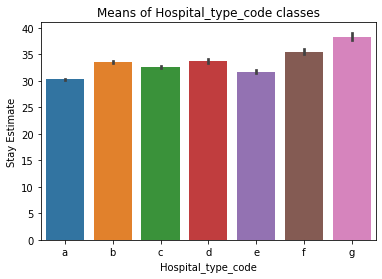

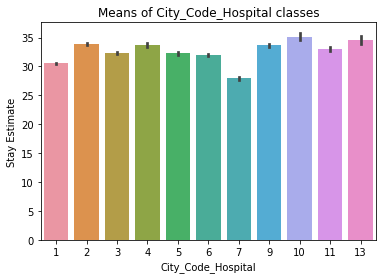

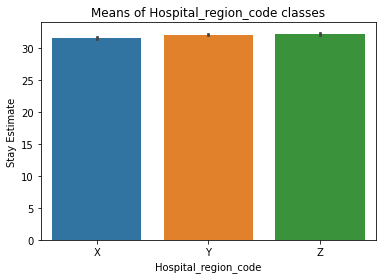

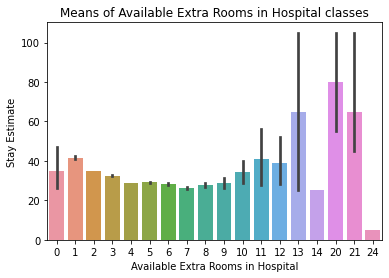

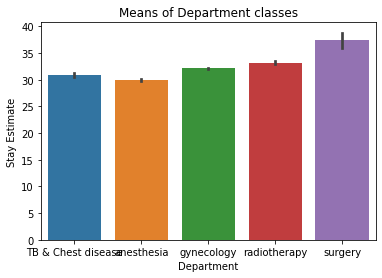

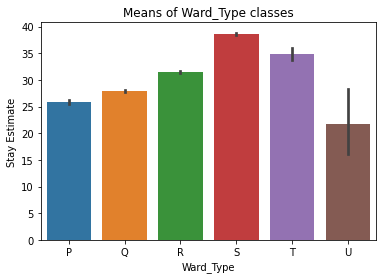

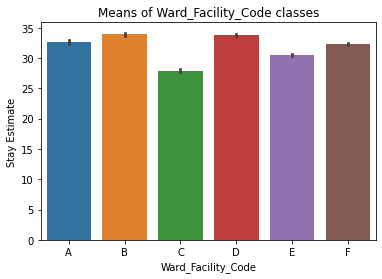

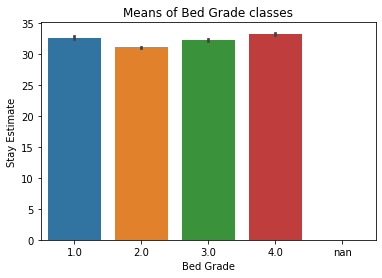

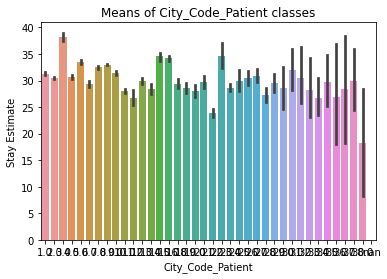

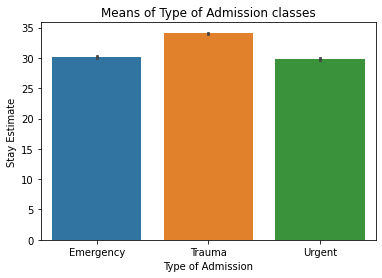

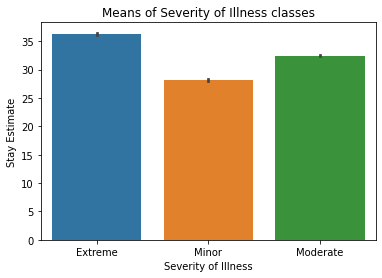

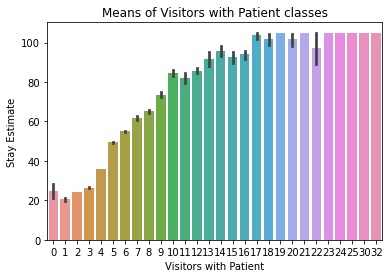

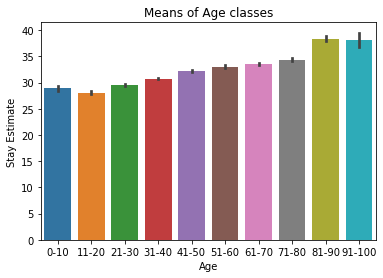

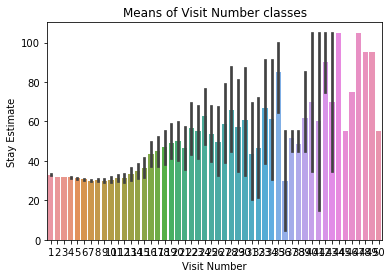

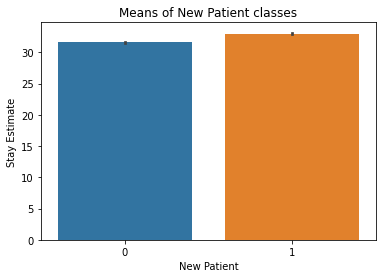

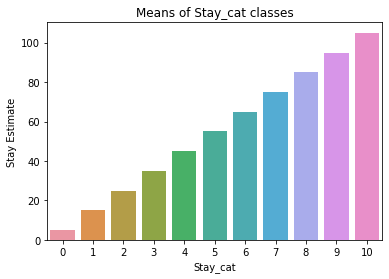

In [28]:
for feature in column_features :
    order = pd.unique(health_care[feature])
    order.sort()
    ax = sns.barplot(x=feature, y="Stay Estimate", data=health_care,order=order, estimator=mean)
    ax.set_title(f'Means of {feature} classes') 
    plt.show();
    
    
    
    

## Conclusion :

Feature that appear to have some influence on the mean of the stay : 
- Hospital_code
- Available Extra Room : To verifiy if the amount of available data is conclusive 
- Ward_Type
- City_Code_Patient
- Type Of Admission
- Severity of Illness
- Visitors with Patient : To verify since maybe it's correlated to the length of stay
- Age

The 2 features that seem to have a good prediction power from the plot are :
- Visitor with Patient
- Age

**Remark** : Data source doesn't specify if the visitor with patient is correlated to the time of stay ? 

## Median Analysis


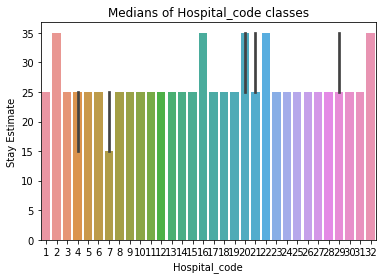

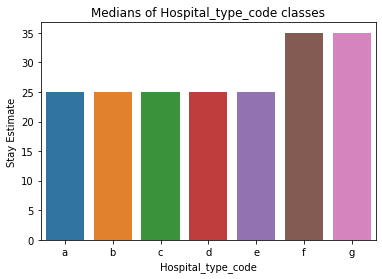

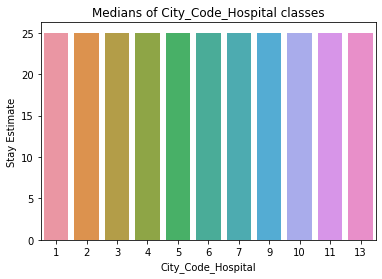

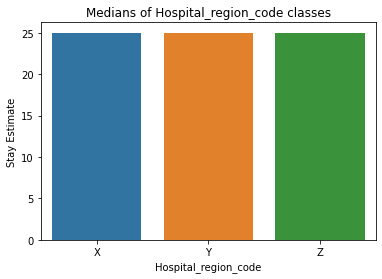

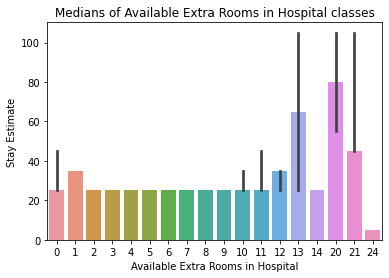

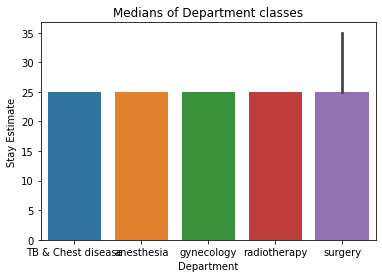

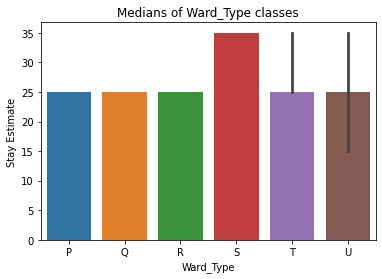

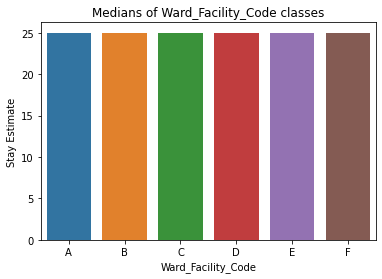

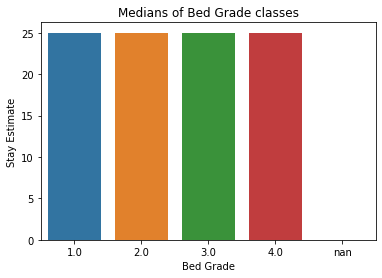

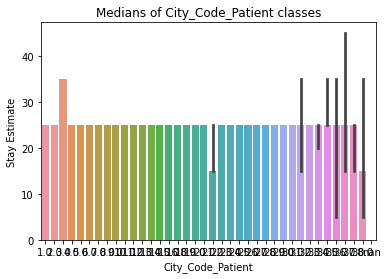

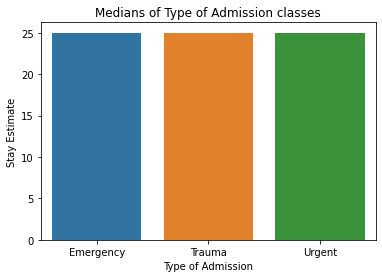

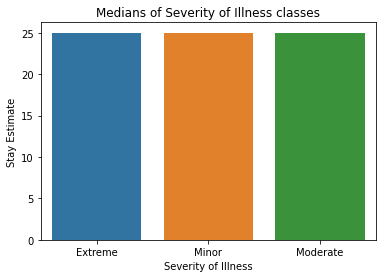

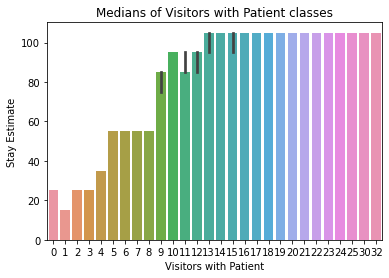

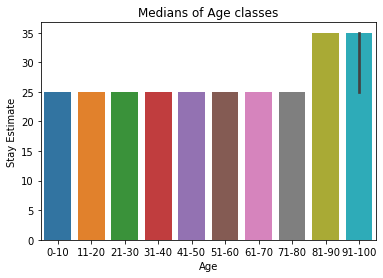

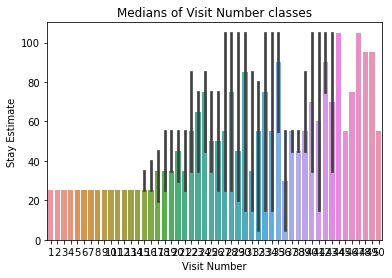

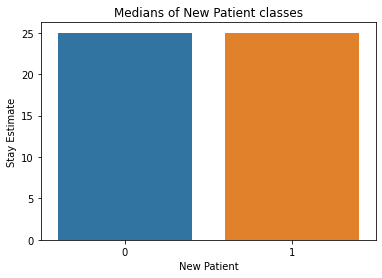

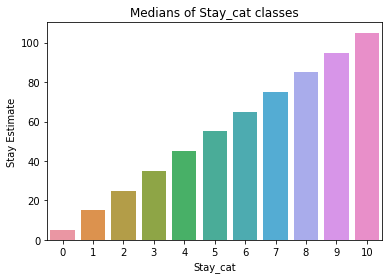

In [29]:
for feature in column_features :
    order = pd.unique(health_care[feature])
    order.sort()
    ax = sns.barplot(x=feature, y="Stay Estimate", data=health_care,order=order, estimator=median)
    ax.set_title(f'Medians of {feature} classes') 
    plt.show();
    
    
    
    

## Conclusion :

Feature that appear to have some influence on the median of the stay : 
- Hospital_code
- Hospital_type_code
- Available Extra Room : To verifiy if the amount of available data is conclusive 
- Ward_Type
- City_Code_Patient
- Visitors with Patient : To verify since maybe it's correlated to the length of stay
- Age

## Analysis of Std

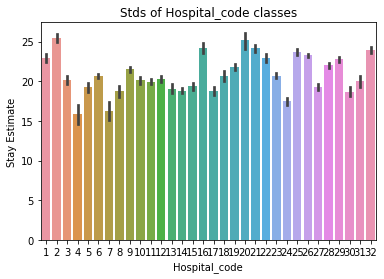

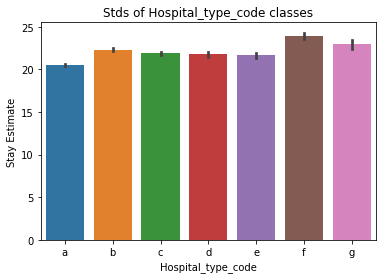

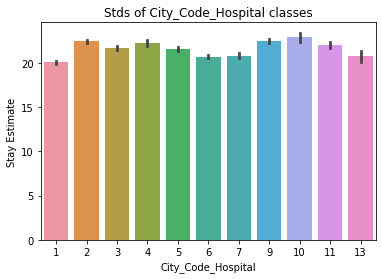

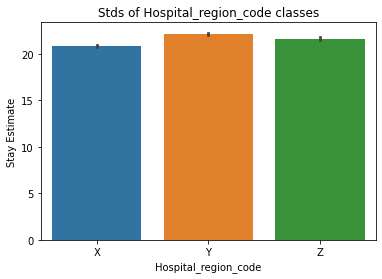

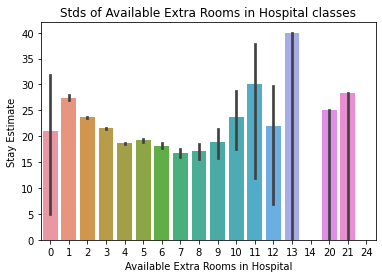

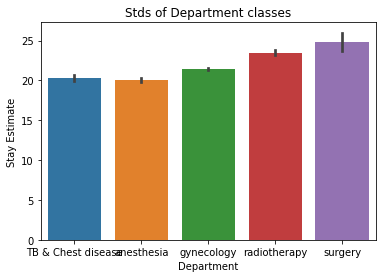

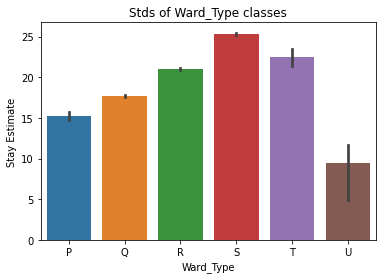

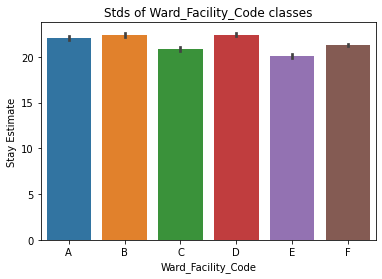

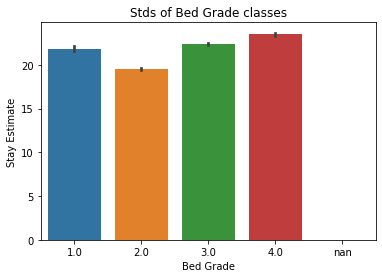

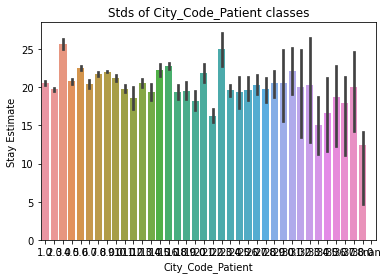

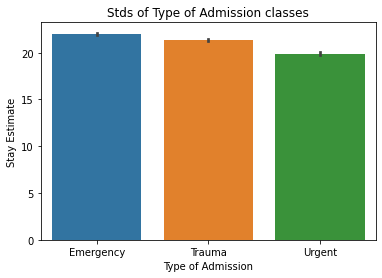

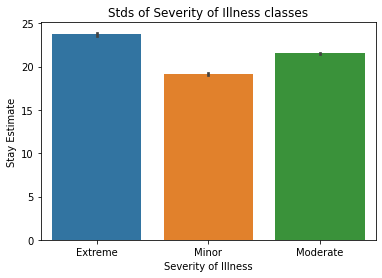

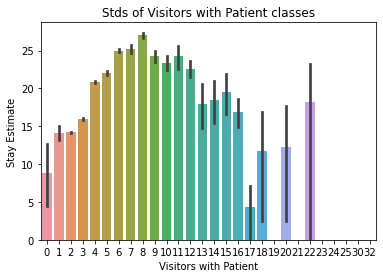

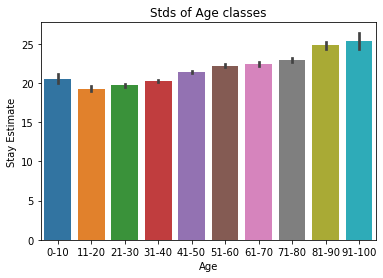

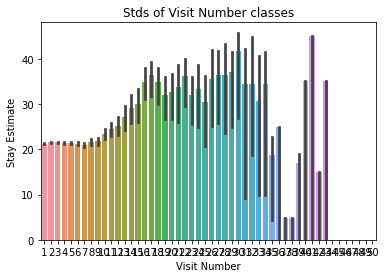

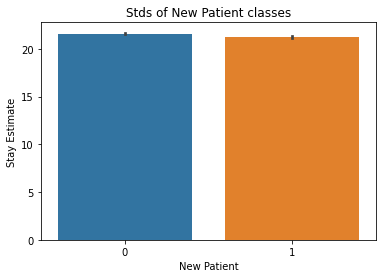

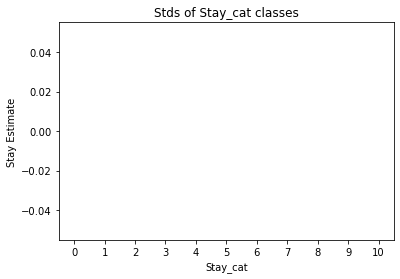

In [30]:
for feature in column_features :
    order = pd.unique(health_care[feature])
    order.sort()
    ax = sns.barplot(x=feature, y="Stay Estimate", data=health_care,order=order, estimator=std)
    ax.set_title(f'Stds of {feature} classes') 
    plt.show();
    
    
    
    

## Conclusion :

Feature that appear to have some influence on the median of the stay : 
- Hospital_code
- Available Extra Room : To verifiy if the amount of available data is conclusive 
- Ward_Type
- City_Code_Patient
- Severity of Illness
- Type Of Admission
- Visitors with Patient : To verify since maybe it's correlated to the length of stay
- Age

[Back to top](#Content:)

<a id='part3'></a>
### Part 3 - Preparing our data

We saw in Part 2 that columns **"Bed Grade"** and **"City_Code_patient"** have missing values. Before deciding whether we shall drop these columns or keep some of them and try to fill the missing values with medians, we can make and analysis to understand the percentage of missing values by creating this function **"perc_mv"**.


In [31]:
def perc_mv(x, y):
    perc = y.isnull().sum() / len(x) * 100
    return perc

In [32]:
print('Missing value ratios:\nBed Grade: {}\nCity_Code_Patient: {}'.format(
    perc_mv(df, df['Bed Grade']),
    perc_mv(df, df['City_Code_Patient'])))

Missing value ratios:
Bed Grade: 0.035485714644609
City_Code_Patient: 1.4231969802598936


**As we can see, 0.03% of Bed Grade column and 1.42% of City_Code_Patient has missing values. Therefore, we have enough values to fill the rows of the company column via any imputation method.**

In [33]:
# Assuming importance of the City_Code_Patient in the future analysis is minimalistic
# let s drop it 

df = df.drop(['City_Code_Patient'], axis = 1)

In [34]:
#let's fill missing values of 'Bed Grade' with its median of the column
med = df['Bed Grade'].median()
df['Bed Grade'] = df['Bed Grade'].fillna(med)

In [35]:
#missing values check after data manipulation
df.isnull().values.any()

False

Next, we may want to check the features to create some more meaningful variables and reduce the number of features.


In [36]:
#????think of smth to work on the type
#In the code cell below, we use the attribute dtype on df to retrieve the data type for each column.
print (df.dtypes)

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object


In [37]:
#We want to map the name of each Severity of Illness to the corresponding number in ascending order.
df['Severity of Illness'] = df['Severity of Illness'].map({'Minor':1, 'Moderate': 2, 'Extreme':3})
df['Type of Admission'] = df['Type of Admission'].map({'Trauma':1, 'Emergency': 2, 'Urgent':3})
df

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,2,3,2,51-60,4911.0,0-10
136814,136815,28,b,11,X,2,gynecology,R,F,3.0,112307,2,2,2,21-30,4517.0,0-10
136815,136816,29,a,4,X,3,gynecology,S,F,3.0,112307,2,2,2,21-30,3846.0,0-10
136823,136824,11,b,2,Y,4,gynecology,Q,D,4.0,64198,2,2,2,21-30,5183.0,0-10
136837,136838,14,a,1,X,3,gynecology,R,E,3.0,76865,2,3,3,51-60,3452.0,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68359,68360,10,e,1,X,2,gynecology,S,E,3.0,113737,1,2,6,61-70,4345.0,More than 100 Days
15335,15336,18,d,13,Y,2,gynecology,R,B,3.0,17210,1,2,8,71-80,4413.0,More than 100 Days
15334,15335,18,d,13,Y,2,gynecology,R,B,3.0,17210,1,2,8,71-80,3080.0,More than 100 Days
31499,31500,26,b,2,Y,2,gynecology,Q,D,3.0,79939,1,2,20,51-60,5087.0,More than 100 Days


For now, we assume these columns are not important for our analysis:

0case_id

1Hospital_code 

2Hospital_type_code

3City_Code_Hospital  

7Ward_Type - anyways we know department, so we can guess the ward type

8Ward_Facility_Code

In [38]:
#dropping unwanted columns
df.drop(df.columns[0:4],axis=1, inplace=True)
df.drop(df.columns[3:5], axis=1, inplace=True)
print(df.shape)
df

(318438, 11)


,Hospital_region_code,Available Extra Rooms in Hospital,Department,Bed Grade,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,Z,3,radiotherapy,2.0,31397,2,3,2,51-60,4911.0,0-10
136814,X,2,gynecology,3.0,112307,2,2,2,21-30,4517.0,0-10
136815,X,3,gynecology,3.0,112307,2,2,2,21-30,3846.0,0-10
136823,Y,4,gynecology,4.0,64198,2,2,2,21-30,5183.0,0-10
136837,X,3,gynecology,3.0,76865,2,3,3,51-60,3452.0,0-10
...,...,...,...,...,...,...,...,...,...,...,...
68359,X,2,gynecology,3.0,113737,1,2,6,61-70,4345.0,More than 100 Days
15335,Y,2,gynecology,3.0,17210,1,2,8,71-80,4413.0,More than 100 Days
15334,Y,2,gynecology,3.0,17210,1,2,8,71-80,3080.0,More than 100 Days
31499,Y,2,gynecology,3.0,79939,1,2,20,51-60,5087.0,More than 100 Days


In [39]:
#using LabelEncoder to change and transform the object format of 
#'Hospital_region_code','Department','Age', 'Stay' columns
le = LabelEncoder()
for col in ['Hospital_region_code','Department','Age', 'Stay']:
    df[col]= df[col].astype('str')
    df[col]= le.fit_transform(df[col])
print (df.dtypes)

Hospital_region_code                   int32
Available Extra Rooms in Hospital      int64
Department                             int32
Bed Grade                            float64
patientid                              int64
Type of Admission                      int64
Severity of Illness                    int64
Visitors with Patient                  int64
Age                                    int32
Admission_Deposit                    float64
Stay                                   int32
dtype: object


In [40]:
#shuffling
df= df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

[Back to top](#Content:)

<a id='part4'></a>
### Part 4 - Correlation

One way to decide which features are going to be more impactful when running an analysis is to look at the correlation between them.

Pearson's correlations are single value numerical summaries that represent the strength and direction of a linear relationship. Correlation values range from -1 to 1. Values further away from 0 represent stronger relationships, and the sign of the correlation (positive or negative) represents the direction of the relationship. The graphs below depict a visual representation of Pearson correlations.

In [41]:
#creating a copy of df to have an original for further manipulation
cor_df = df.copy()

In [42]:
#creating a copy of df to have an original for further manipulation
corr = health_care.copy()

In [43]:
#We want to map the name of each Severity of Illness to the corresponding number in ascending order.
corr['Severity of Illness'] = corr['Severity of Illness'].map({'Minor':1, 'Moderate': 2, 'Extreme':3})
corr['Type of Admission'] = corr['Type of Admission'].map({'Trauma':1, 'Emergency': 2, 'Urgent':3})


In [44]:
corr['Age Estimate'] = le.fit_transform(corr['Age']) 

In [45]:
corr['Age Estimate'] = 10*corr['Age Estimate']+5

In [46]:
corr_col = ['Hospital_code', 'City_Code_Hospital','Available Extra Rooms in Hospital','Bed Grade','Type of Admission','Severity of Illness','Visitors with Patient','Admission_Deposit','Age Estimate','Stay Estimate']
corr = corr[corr_col]

In [47]:
corr.head()

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Admission_Deposit,Age Estimate,Stay Estimate
0,8,3,3,2.0,2,3,2,4911.0,55,5
1,2,5,2,2.0,1,3,2,5954.0,55,45
2,10,1,2,2.0,1,3,2,4745.0,55,35
3,26,2,2,2.0,1,3,2,7272.0,55,45
4,26,2,2,2.0,1,3,2,5558.0,55,45


In [48]:
cr = corr.corr()

In [49]:
cr

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Admission_Deposit,Age Estimate,Stay Estimate
Hospital_code,1.000000,0.128294,-0.059638,-0.013739,-0.004417,0.030949,-0.028500,0.045446,0.016322,0.042846
City_Code_Hospital,0.128294,1.000000,-0.045771,-0.049309,0.032415,0.026350,0.018184,-0.034455,0.020507,0.006381
Available Extra Rooms in Hospital,-0.059638,-0.045771,1.000000,-0.115868,0.041737,-0.003307,0.096714,-0.143739,-0.133491,-0.121120
Bed Grade,-0.013739,-0.049309,-0.115868,1.000000,-0.049811,-0.284545,0.088945,0.073833,0.001732,0.025741
Type of Admission,-0.004417,0.032415,0.041737,-0.049811,1.000000,-0.047165,-0.021020,-0.075895,-0.100903,-0.084072
Severity of Illness,0.030949,0.026350,-0.003307,-0.284545,-0.047165,1.000000,0.047292,-0.070892,0.125232,0.126160
Visitors with Patient,-0.028500,0.018184,0.096714,0.088945,-0.021020,0.047292,1.000000,-0.150358,0.073795,0.537537
Admission_Deposit,0.045446,-0.034455,-0.143739,0.073833,-0.075895,-0.070892,-0.150358,1.000000,0.025182,-0.052077
Age Estimate,0.016322,0.020507,-0.133491,0.001732,-0.100903,0.125232,0.073795,0.025182,1.000000,0.094163
Stay Estimate,0.042846,0.006381,-0.121120,0.025741,-0.084072,0.126160,0.537537,-0.052077,0.094163,1.000000


**Remark** :
It seems that visitors with patient is the variable that explains most of variance in the stay estimate, it might be usefull to use a linear regression with only visitors with patient and see results

In [50]:
cr['Stay Estimate'].sort_values(ascending=False)

Stay Estimate                        1.000000
Visitors with Patient                0.537537
Severity of Illness                  0.126160
Age Estimate                         0.094163
Hospital_code                        0.042846
Bed Grade                            0.025741
City_Code_Hospital                   0.006381
Admission_Deposit                   -0.052077
Type of Admission                   -0.084072
Available Extra Rooms in Hospital   -0.121120
Name: Stay Estimate, dtype: float64

In [51]:
## Checking abs value of correlations
cr['Stay Estimate'].abs().sort_values(ascending=False)

Stay Estimate                        1.000000
Visitors with Patient                0.537537
Severity of Illness                  0.126160
Available Extra Rooms in Hospital    0.121120
Age Estimate                         0.094163
Type of Admission                    0.084072
Admission_Deposit                    0.052077
Hospital_code                        0.042846
Bed Grade                            0.025741
City_Code_Hospital                   0.006381
Name: Stay Estimate, dtype: float64

## Features to most likely drop :
- City_Code_Hospital  
- Bed Grade 

These 2 features seemed useless before too ...

## Categorical data correlation

In [52]:
# using from sklearn.preprocessing LabelEncoder 

In [53]:
cor_df['Stay'] = le.fit_transform(cor_df['Stay']) 

In [54]:
#use corr() on cor_df
cor_df.corr()

,Hospital_region_code,Available Extra Rooms in Hospital,Department,Bed Grade,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
Hospital_region_code,1.000000,-0.006906,0.041499,-0.042680,-0.002083,0.058217,0.029454,-0.019485,-0.017083,0.075092,0.011905
Available Extra Rooms in Hospital,-0.006906,1.000000,0.047726,-0.115804,0.000921,0.041737,-0.003307,0.096714,-0.133491,-0.143739,-0.121120
Department,0.041499,0.047726,1.000000,-0.096745,0.002217,0.052736,0.004872,0.026054,0.035518,-0.080754,0.033287
Bed Grade,-0.042680,-0.115804,-0.096745,1.000000,0.001638,-0.049850,-0.284407,0.088920,0.001717,0.073779,0.025761
patientid,-0.002083,0.000921,0.002217,0.001638,1.000000,0.004391,-0.006397,0.006889,-0.001505,-0.000877,0.001125
Type of Admission,0.058217,0.041737,0.052736,-0.049850,0.004391,1.000000,-0.047165,-0.021020,-0.100903,-0.075895,-0.084072
Severity of Illness,0.029454,-0.003307,0.004872,-0.284407,-0.006397,-0.047165,1.000000,0.047292,0.125232,-0.070892,0.126160
Visitors with Patient,-0.019485,0.096714,0.026054,0.088920,0.006889,-0.021020,0.047292,1.000000,0.073795,-0.150358,0.537537
Age,-0.017083,-0.133491,0.035518,0.001717,-0.001505,-0.100903,0.125232,0.073795,1.000000,0.025182,0.094163
Admission_Deposit,0.075092,-0.143739,-0.080754,0.073779,-0.000877,-0.075895,-0.070892,-0.150358,0.025182,1.000000,-0.052077


In [55]:
#Because we want to try to predict the likelihood of a length of stay depending on the type of admission, it is useful to visualise the sorted correlation values for the column Type of Admission.
# here, we are appling sort_values() to visualise the correlation values in a descending order.
cor_df.corr()['Type of Admission'].sort_values(ascending=False)

Type of Admission                    1.000000
Hospital_region_code                 0.058217
Department                           0.052736
Available Extra Rooms in Hospital    0.041737
patientid                            0.004391
Visitors with Patient               -0.021020
Severity of Illness                 -0.047165
Bed Grade                           -0.049850
Admission_Deposit                   -0.075895
Stay                                -0.084072
Age                                 -0.100903
Name: Type of Admission, dtype: float64

In [56]:
#let's examine likelihood of a length of stay depending on the Severity of Illness.

cor_df.corr()['Severity of Illness'].sort_values(ascending=False)

Severity of Illness                  1.000000
Stay                                 0.126160
Age                                  0.125232
Visitors with Patient                0.047292
Hospital_region_code                 0.029454
Department                           0.004872
Available Extra Rooms in Hospital   -0.003307
patientid                           -0.006397
Type of Admission                   -0.047165
Admission_Deposit                   -0.070892
Bed Grade                           -0.284407
Name: Severity of Illness, dtype: float64

In [57]:
#???What is the most impactful feature?

## new addition - Multicollinearity check + PCA - T

<AxesSubplot:>

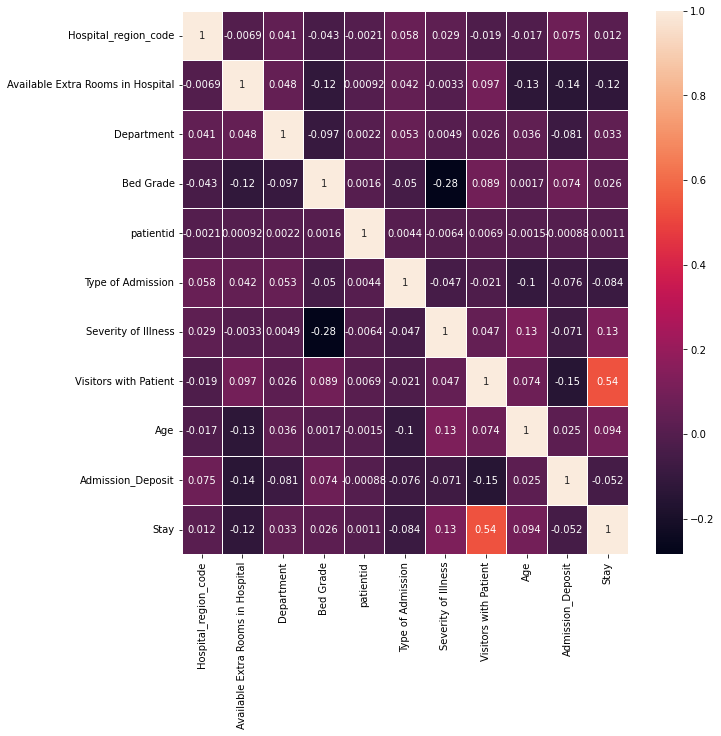

In [58]:
# Heatmap

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))        
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax)

In [68]:
import statsmodels.api as sm
X = df.drop(columns=["Stay"])
y = df["Stay"]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Stay   R-squared (uncentered):                   0.741
Model:                            OLS   Adj. R-squared (uncentered):              0.741
Method:                 Least Squares   F-statistic:                          9.099e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):                        0.00
Time:                        17:25:38   Log-Likelihood:                     -6.3127e+05
No. Observations:              318438   AIC:                                  1.263e+06
Df Residuals:                  318428   BIC:                                  1.263e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_VIF = df
data = pd.DataFrame()
data["feature"] = X_VIF.columns
data["VIF"] = [variance_inflation_factor(X_VIF.values, i) for i in range(len(X_VIF.columns))]
print(data)

                              feature        VIF
0                Hospital_region_code   2.097252
1   Available Extra Rooms in Hospital   7.957268
2                          Department  11.291869
3                           Bed Grade   9.110812
4                           patientid   3.873040
5                   Type of Admission   5.932699
6                 Severity of Illness   8.680884
7               Visitors with Patient   6.686882
8                                 Age   5.825253
9                   Admission_Deposit  15.413080
10                               Stay   3.857603


In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Choosing the number of components
X = df.drop(columns=["Stay"])
y = df["Stay"]
X_std = StandardScaler().fit_transform(X)
pca = PCA().fit(X_std)

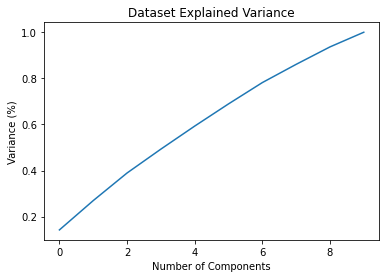

In [73]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [74]:
np.cumsum(pca.explained_variance_ratio_)

array([0.14217335, 0.2694108 , 0.38918835, 0.49279043, 0.59273012,
       0.68901815, 0.78153649, 0.86067056, 0.93636789, 1.        ])

In [75]:
# For our analysis we choose n_components = 7
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_std)
X_pca_with_constant = sm.add_constant(X_pca)

In [76]:
model = sm.OLS(y, X_pca_with_constant)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Stay   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                 1.354e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:27:38   Log-Likelihood:            -6.5413e+05
No. Observations:              318438   AIC:                         1.308e+06
Df Residuals:                  318430   BIC:                         1.308e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6986      0.003    806.776      0.0

In [78]:
# from sklearn.svm import SVC

In [79]:
# X_train, X_test, y_train, y_test = train_test_split(X_pca_with_constant, y, test_size=0.3, random_state=0)
# model = SVC (kernel, C=10)
# model.fit(X_train, y_train)
# y_model = model.predict(X_test)

# accuracy_score(y_test, y_model)

In [81]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X_pca_with_constant, y)
a, b, score = model.coef_, model.intercept_, model.score(X_pca_with_constant, y)
print('score : %.2f' % score)

score : 0.23


## new addition -SMOTE - T


Under the hood, the SMOTE algorithm works in 4 simple steps:
- Choose a minority class input vector
- Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
- Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
- Repeat the steps until data is balanced

<AxesSubplot:>

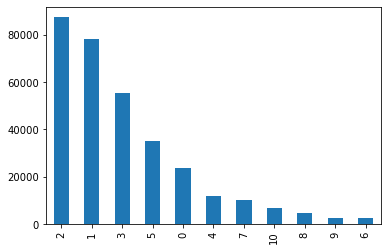

In [82]:
df["Stay"].value_counts().plot.bar()

In [83]:
print('Proportion of the different lenght of stay in the data:')
print(df["Stay"].value_counts() / len(data))

Proportion of the different lenght of stay in the data:
2     7953.727273
1     7103.545455
3     5014.454545
5     3183.454545
0     2145.818182
4     1067.545455
7      932.181818
10     607.545455
8      439.818182
9      251.363636
6      249.454545
Name: Stay, dtype: float64


In [84]:
df_2 = df.copy()

X = np.array(df_2.loc[:, df_2.columns != "Stay"])
y = np.array(df_2.loc[:, df_2.columns == "Stay"]).reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2, shuffle = True, stratify = y)


In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(solver = 'lbfgs')

## Without SMOTE

In [87]:
# fit the model
clf.fit(X_train, y_train)

# prediction for training dataset
train_pred = clf.predict(X_train)

# prediction for testing dataset
test_pred = clf.predict(X_test)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [88]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred, y_train))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred, y_test))

Accuracy score for Training Dataset =  0.3602902232450446
Accuracy score for Testing Dataset =  0.3597088071561117


In [89]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train.ravel(), train_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted    0      1      2      3      5    10     All
True                                                    
0          105   6828   7985    798     99     0   15815
1           78  20215  26148   4273   1632     7   52353
2          112  15969  38064   3244   1193    37   58619
3           84   7812  15010   8482   5477    91   36956
4           35   2003   4400    842    538    50    7868
5           22   2606   4786   7211   8569   268   23462
6            8    322    906    241    319    42    1838
7           15    642   1070   2143   2631   369    6870
8            6    139    217    411   2205   263    3241
9            2    142    303    522    657   227    1853
10           8    182    371    440   2043  1434    4478
All        475  56860  99260  28607  25363  2788  213353


In [90]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test.ravel(), test_pred.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted    0      1      2      3      5    10     All
True                                                    
0           58   3373   3937    367     54     0    7789
1           45   9906  12871   2081    880     3   25786
2           60   7770  18857   1593    563    29   28872
3           32   3933   7449   4120   2623    46   18203
4           25    950   2245    414    212    29    3875
5           24   1226   2369   3624   4182   131   11556
6            5    153    456    124    152    16     906
7            3    326    574   1025   1269   187    3384
8            0     69    108    176   1115   129    1597
9            5     83    153    236    337    98     912
10           2     88    197    225   1016   677    2205
All        259  27877  49216  13985  12403  1345  105085


## SMOTE wtih PCA X

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_with_constant, y, test_size = 0.33, random_state = 2, shuffle = True, stratify = y)
clf = LogisticRegression(solver = 'lbfgs')

In [98]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state = 33)
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

<AxesSubplot:>

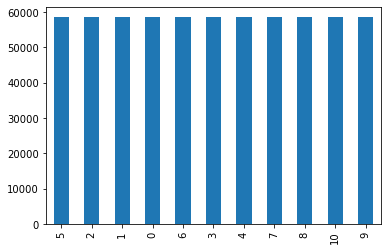

In [99]:
# observe that data has been balanced
pd.Series(y_train_SMOTE).value_counts().plot.bar()

In [100]:
# fit the model
clf.fit(X_train_SMOTE, y_train_SMOTE)

# prediction for Training data
train_pred_sm = clf.predict(X_train_SMOTE)

# prediction for Testing data
test_pred_sm = clf.predict(X_test)

In [101]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred_sm, y_train_SMOTE))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred_sm, y_test.ravel()))

Accuracy score for Training Dataset =  0.20638204491562617
Accuracy score for Testing Dataset =  0.19761145739163535


## SMOTE only


In [91]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state = 33)
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

<AxesSubplot:>

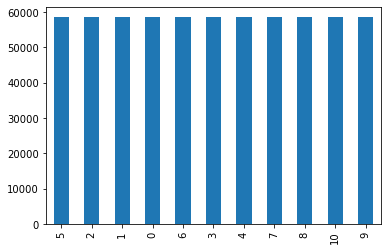

In [92]:
# observe that data has been balanced
pd.Series(y_train_SMOTE).value_counts().plot.bar()

In [93]:
# fit the model
clf.fit(X_train_SMOTE, y_train_SMOTE)

# prediction for Training data
train_pred_sm = clf.predict(X_train_SMOTE)

# prediction for Testing data
test_pred_sm = clf.predict(X_test)

In [94]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred_sm, y_train_SMOTE))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred_sm, y_test.ravel()))

Accuracy score for Training Dataset =  0.2422050560708675
Accuracy score for Testing Dataset =  0.23398201455964218


In [95]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train_SMOTE, train_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted       0      1      2      3      4      5      6      7      8  \
True                                                                        
0           29514   9155   8355   2884   2781    888   4685     96     42   
1           16629  13160  11629   4001   2768   2434   5900    441    660   
2           14229   9465  17997   2979   3248   1286   7893    245    438   
3            9339   5922  10165   5748   2179   7177   7426   2351   3564   
4           12330   8437  14907   3464   3392   2980   9056    649   1425   
5            4881   1854   3225   5386   1026  11367   6448   4259   7181   
6            7700   6016  13834   2927   3005   4079   9921    893   3686   
7            3493   1353   1676   5092    756  10726   6655   4881   6305   
8            2439    515    872   1250    301   3972   1564   2029  18944   
9            2733    888   1754   4071    817   9858   7158   4702   5182   
10           2012    642   1374   1099  

In [96]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test.ravel(), test_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted      0      1      2     3     4     5      6     7     8     9  \
True                                                                        
0           3880   1164   1122   424   360   157    607    19    12    38   
1           7268   5680   5170  1769  1308  1077   2560   188   299   377   
2           6803   4762   8816  1425  1604   625   4077   139   223   283   
3           2976   1884   3247  1688   656  2218   2291   705  1087  1086   
4            863    551    965   230   211   186    585    44    95    87   
5            994    368    725  1017   152  2172   1341   785  1393  1784   
6            123     93    214    45    34    57    146    27    73    58   
7            232     94    137   283    42   578    371   257   408   548   
8             78     18     30    30     2   122     49    39   496   241   
9             62     24     29    63    10   123    113    73    89   164   
10           108     28     69    49     

[Back to top](#Content:)


<a id='part5'></a>

## Part 5 - Splitting our data for modelling

In [59]:
#using from sklearn.model_selection import train_test_split model

In [60]:
# X = df.drop(columns=["Stay"])
# y = df["Stay"]
# print(X.shape)
# print(y.shape)


(318438, 10)
(318438,)


In [61]:
# #test size = 20%, train size = 80%
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [62]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()

# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)


In [63]:
# #creating Perceptron
# ppn = Perceptron(max_iter=40, tol = 0.001, eta0=1)

In [64]:
# #train the model
# ppn.fit(X_train_std, y_train)

In [65]:
# #make prediction
# y_pred = ppn.predict(X_test_std)

In [66]:
# #accuracy
# print('Accuracy: %.2f' %accuracy_score(y_test,y_pred)) -20smth %, need to work on it 

In [67]:
# from sklearn.model_selection import KFold
# from sklearn.tree import DecisionTreeClassifier
# decision_tree = DecisionTreeClassifier (criterion = "entropy")


# kf = KFold(5)
# fold = 1
# for train_index, validate_index in kf.split(X,y):
#     decision_tree.fit(X[train_index], y[train_index])
#     y_test= y[validate_index]
#     y_pred = decision_tree.predict(X[validate_index])
#     print (f"Fold #{fold}, Training Size: {len(X[train_index])}, Validation Size: {len(X[validate_index])}")
#     print("Accuracy: %.2f" %accuracy_score(y_test,y_pred))

# Data preparation - Baraa

# Hot encoded Data

In [5]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) ## inplace to make changed on the original df

In [6]:
## Pre processing these columns

le_string_columns = [  'Severity of Illness', 'Age' ]
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()
#ohEncoder = OneHotEncoder()

## label_encoded data
Xe = health_care.drop(['Stay', 'case_id', 'City_Code_Hospital','City_Code_Patient', 'Bed Grade'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = health_care['Stay']
ye = encoder.fit_transform(ye)


for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

## Scaling Hot Encoded Data

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = Xe.values
y = ye
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

[Back to top](#Content:)


<a id='part6'></a>

## Part 6 - Decision Trees

In [9]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [10]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy')

Accuracy : 0.286
Score : 0.85


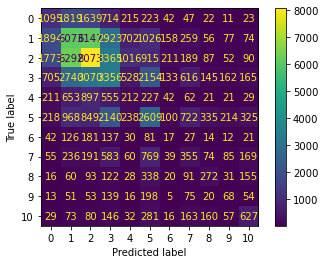

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = tree.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
print(f'Score : %.2f' % score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm )
disp.plot()
plt.show();

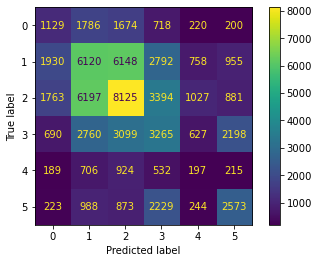

In [32]:
cm_reduced = cm[:6,:6]

cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

## Conclusion :

Most confusion happens within the square 1-3. Also between Cat3 and Cat5

[Back to top](#Content:)


<a id='part7'></a>

## Part 7 - Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [35]:
forest = RandomForestClassifier(n_estimators=10, criterion='entropy')
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

Accuracy : 0.340
Score : 0.8712


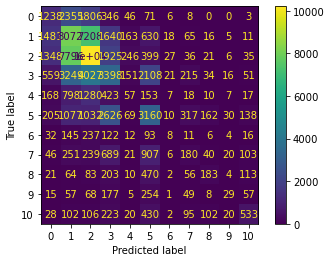

In [36]:
y_pred = forest.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
print(f'Score : %.4f' % score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

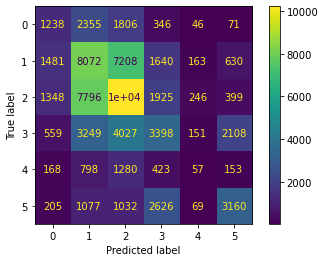

In [37]:
cm_reduced = cm[:6,:6]

cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

In [38]:
### Cross Validating to check some results
kf = KFold(5, shuffle=True)
fold = 1

for train_index, validate_index in kf.split(X,y):
    forest.fit(X[train_index], y[train_index])
    ytest = y[validate_index]
    y_pred = forest.predict(X[validate_index])
    print(f'Accuracy : %.4f' % accuracy_score(ytest, y_pred))
    print(f'Score : %.4f' % score(ytest, y_pred))

Accuracy : 0.3430
Score : 0.8720
Accuracy : 0.3408
Score : 0.8719
Accuracy : 0.3418
Score : 0.8722
Accuracy : 0.3468
Score : 0.8726
Accuracy : 0.3444
Score : 0.8727


### Trying Different num of estimators

In [39]:
accuracy_data = []
score_data = []

for i in range(1,40):
    forest = RandomForestClassifier(n_estimators=i, criterion='entropy')
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    score = 1-np.mean(np.abs(y_test-y_pred))/K
    print(f'Accuracy {i} estimators : %.4f' % accuracy)
    print(f'Score {i} estimators : %.4f' % score)
    accuracy_data.append(accuracy)
    score_data.append(score)
    
    

Accuracy 1 estimators : 0.2799
Score 1 estimators : 0.8453
Accuracy 2 estimators : 0.2972
Score 2 estimators : 0.8555
Accuracy 3 estimators : 0.2955
Score 3 estimators : 0.8521
Accuracy 4 estimators : 0.3106
Score 4 estimators : 0.8586
Accuracy 5 estimators : 0.3226
Score 5 estimators : 0.8642
Accuracy 6 estimators : 0.3272
Score 6 estimators : 0.8660
Accuracy 7 estimators : 0.3306
Score 7 estimators : 0.8679
Accuracy 8 estimators : 0.3374
Score 8 estimators : 0.8700
Accuracy 9 estimators : 0.3381
Score 9 estimators : 0.8700
Accuracy 10 estimators : 0.3439
Score 10 estimators : 0.8720
Accuracy 11 estimators : 0.3440
Score 11 estimators : 0.8720
Accuracy 12 estimators : 0.3445
Score 12 estimators : 0.8732
Accuracy 13 estimators : 0.3481
Score 13 estimators : 0.8739
Accuracy 14 estimators : 0.3479
Score 14 estimators : 0.8740
Accuracy 15 estimators : 0.3492
Score 15 estimators : 0.8746
Accuracy 16 estimators : 0.3493
Score 16 estimators : 0.8749
Accuracy 17 estimators : 0.3524
Score 17 e

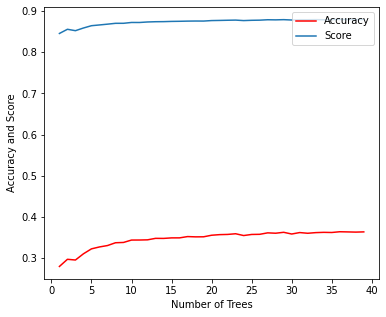

In [41]:
nums = np.arange(1,40)
fig = plt.figure(figsize=(6,5))
plt.plot(nums, accuracy_data, c='r', label='Accuracy')
plt.plot(nums, score_data, label='Score')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy and Score')
plt.legend(loc='upper right')
plt.show();

## Last Model results

Accuracy : 0.364
Score : 0.8792


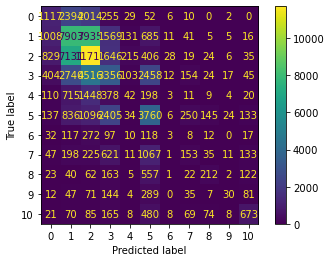

In [43]:
y_pred = forest.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
score = 1-np.mean(np.abs(y_test-y_pred))/K
print(f'Score : %.4f' % score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

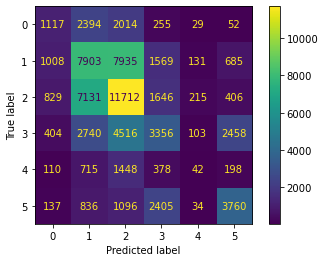

In [44]:
cm_reduced = cm[:6,:6]

cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

## Conclusion :
Same conclusion as before 

[Back to top](#Content:)


<a id='part8'></a>

## Part 8 - Naive Bayes

In [48]:
from sklearn.naive_bayes import GaussianNB
smoothing = [1e-3, 1e-2, 1e-1, 1, 10,100]


Let's try different smoothing values

In [49]:
for i in range(len(smoothing)):
    model = GaussianNB(var_smoothing=smoothing[i])
    model.fit(X_test, y_test)
    y_pred = model.predict(X_test)
    print('var_smoothing = ',smoothing[i] )
    print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
    score = 1-np.mean(np.abs(y_test-y_pred))/K
    print(f'Score : %.4f' % score)
    print('---------' )


var_smoothing =  0.001
Accuracy : 0.285
Score : 0.8359
---------
var_smoothing =  0.01
Accuracy : 0.286
Score : 0.8364
---------
var_smoothing =  0.1
Accuracy : 0.294
Score : 0.8413
---------
var_smoothing =  1
Accuracy : 0.314
Score : 0.8510
---------
var_smoothing =  10
Accuracy : 0.285
Score : 0.8514
---------
var_smoothing =  100
Accuracy : 0.277
Score : 0.8517
---------


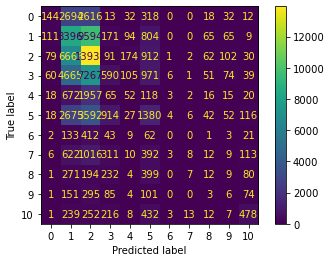

In [50]:
## Keeping smoothing = 1
model = GaussianNB(var_smoothing=1)
model.fit(X_test, y_test)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

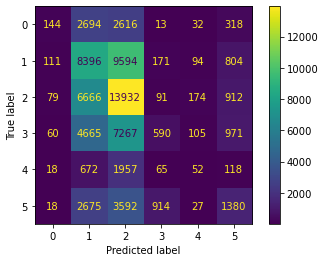

In [51]:
cm_reduced = cm[:6,:6]

cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

[Back to top](#Content:)


<a id='part9'></a>

## Part 9 - Gradient Boost Classifier


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [12]:
y_pred = model.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
score = 1-np.mean(np.abs(y_test-y_pred))/K
print(f'Score : %.4f' % score)

Accuracy : 0.399
Score : 0.8906


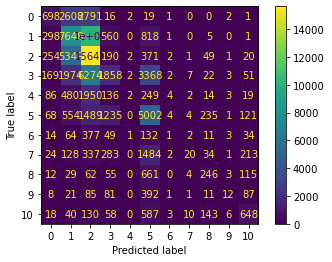

In [13]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

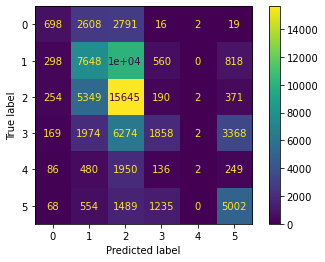

In [14]:
cm_reduced = cm[:6,:6]

cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

# Conclusion :

Slightly better results than Random Forest.

Confusion is high when true label is when and its predicted 2, and when true label is 3 and is predicted 2. The model tends to predict category 2 a lot.

[Back to top](#Content:)


<a id='part10'></a>

## Part 10 - Cat Boost Classifier


In [12]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(iterations=1000)


In [13]:
cb.fit(X_train, y_train)

Learning rate set to 0.104618
0:	learn: 2.2285143	total: 175ms	remaining: 2m 54s
1:	learn: 2.1123450	total: 291ms	remaining: 2m 25s
2:	learn: 2.0256598	total: 400ms	remaining: 2m 12s
3:	learn: 1.9567562	total: 503ms	remaining: 2m 5s
4:	learn: 1.9008294	total: 617ms	remaining: 2m 2s
5:	learn: 1.8561153	total: 719ms	remaining: 1m 59s
6:	learn: 1.8178372	total: 823ms	remaining: 1m 56s
7:	learn: 1.7866962	total: 927ms	remaining: 1m 54s
8:	learn: 1.7597465	total: 1.03s	remaining: 1m 54s
9:	learn: 1.7373371	total: 1.14s	remaining: 1m 52s
10:	learn: 1.7171465	total: 1.25s	remaining: 1m 52s
11:	learn: 1.7004949	total: 1.35s	remaining: 1m 51s
12:	learn: 1.6856964	total: 1.46s	remaining: 1m 51s
13:	learn: 1.6715168	total: 1.57s	remaining: 1m 50s
14:	learn: 1.6592214	total: 1.69s	remaining: 1m 50s
15:	learn: 1.6494962	total: 1.8s	remaining: 1m 51s
16:	learn: 1.6407207	total: 1.92s	remaining: 1m 51s
17:	learn: 1.6327938	total: 2.03s	remaining: 1m 50s
18:	learn: 1.6249243	total: 2.15s	remaining: 1m

157:	learn: 1.5162049	total: 18.9s	remaining: 1m 40s
158:	learn: 1.5158530	total: 19s	remaining: 1m 40s
159:	learn: 1.5155534	total: 19.1s	remaining: 1m 40s
160:	learn: 1.5153661	total: 19.2s	remaining: 1m 40s
161:	learn: 1.5150679	total: 19.4s	remaining: 1m 40s
162:	learn: 1.5149075	total: 19.5s	remaining: 1m 40s
163:	learn: 1.5146546	total: 19.6s	remaining: 1m 39s
164:	learn: 1.5144865	total: 19.7s	remaining: 1m 39s
165:	learn: 1.5141060	total: 19.9s	remaining: 1m 39s
166:	learn: 1.5139597	total: 20s	remaining: 1m 39s
167:	learn: 1.5136620	total: 20.1s	remaining: 1m 39s
168:	learn: 1.5134760	total: 20.3s	remaining: 1m 39s
169:	learn: 1.5132688	total: 20.4s	remaining: 1m 39s
170:	learn: 1.5130892	total: 20.5s	remaining: 1m 39s
171:	learn: 1.5128556	total: 20.6s	remaining: 1m 39s
172:	learn: 1.5126222	total: 20.7s	remaining: 1m 39s
173:	learn: 1.5122563	total: 20.8s	remaining: 1m 38s
174:	learn: 1.5120020	total: 21s	remaining: 1m 38s
175:	learn: 1.5117943	total: 21.1s	remaining: 1m 38s

313:	learn: 1.4909126	total: 37.7s	remaining: 1m 22s
314:	learn: 1.4907919	total: 37.8s	remaining: 1m 22s
315:	learn: 1.4906417	total: 38s	remaining: 1m 22s
316:	learn: 1.4905492	total: 38.1s	remaining: 1m 22s
317:	learn: 1.4903674	total: 38.2s	remaining: 1m 21s
318:	learn: 1.4903199	total: 38.4s	remaining: 1m 21s
319:	learn: 1.4901716	total: 38.5s	remaining: 1m 21s
320:	learn: 1.4900424	total: 38.6s	remaining: 1m 21s
321:	learn: 1.4899569	total: 38.7s	remaining: 1m 21s
322:	learn: 1.4898262	total: 38.9s	remaining: 1m 21s
323:	learn: 1.4897576	total: 39s	remaining: 1m 21s
324:	learn: 1.4896209	total: 39.1s	remaining: 1m 21s
325:	learn: 1.4894450	total: 39.2s	remaining: 1m 21s
326:	learn: 1.4893356	total: 39.4s	remaining: 1m 20s
327:	learn: 1.4892861	total: 39.5s	remaining: 1m 20s
328:	learn: 1.4890083	total: 39.6s	remaining: 1m 20s
329:	learn: 1.4888082	total: 39.8s	remaining: 1m 20s
330:	learn: 1.4886835	total: 39.9s	remaining: 1m 20s
331:	learn: 1.4884784	total: 40s	remaining: 1m 20s

471:	learn: 1.4717099	total: 57.4s	remaining: 1m 4s
472:	learn: 1.4716207	total: 57.6s	remaining: 1m 4s
473:	learn: 1.4714931	total: 57.7s	remaining: 1m 4s
474:	learn: 1.4713890	total: 57.8s	remaining: 1m 3s
475:	learn: 1.4713283	total: 58s	remaining: 1m 3s
476:	learn: 1.4712057	total: 58.1s	remaining: 1m 3s
477:	learn: 1.4710425	total: 58.2s	remaining: 1m 3s
478:	learn: 1.4708247	total: 58.4s	remaining: 1m 3s
479:	learn: 1.4706819	total: 58.5s	remaining: 1m 3s
480:	learn: 1.4705654	total: 58.6s	remaining: 1m 3s
481:	learn: 1.4704614	total: 58.8s	remaining: 1m 3s
482:	learn: 1.4703485	total: 58.9s	remaining: 1m 3s
483:	learn: 1.4702060	total: 59s	remaining: 1m 2s
484:	learn: 1.4701049	total: 59.1s	remaining: 1m 2s
485:	learn: 1.4699567	total: 59.3s	remaining: 1m 2s
486:	learn: 1.4698609	total: 59.4s	remaining: 1m 2s
487:	learn: 1.4697911	total: 59.5s	remaining: 1m 2s
488:	learn: 1.4696743	total: 59.6s	remaining: 1m 2s
489:	learn: 1.4695160	total: 59.8s	remaining: 1m 2s
490:	learn: 1.46

631:	learn: 1.4548463	total: 1m 18s	remaining: 45.6s
632:	learn: 1.4547455	total: 1m 18s	remaining: 45.5s
633:	learn: 1.4546507	total: 1m 18s	remaining: 45.3s
634:	learn: 1.4545721	total: 1m 18s	remaining: 45.2s
635:	learn: 1.4544647	total: 1m 18s	remaining: 45.1s
636:	learn: 1.4544248	total: 1m 18s	remaining: 45s
637:	learn: 1.4543157	total: 1m 19s	remaining: 44.9s
638:	learn: 1.4542450	total: 1m 19s	remaining: 44.8s
639:	learn: 1.4541026	total: 1m 19s	remaining: 44.6s
640:	learn: 1.4540470	total: 1m 19s	remaining: 44.5s
641:	learn: 1.4539326	total: 1m 19s	remaining: 44.4s
642:	learn: 1.4538387	total: 1m 19s	remaining: 44.3s
643:	learn: 1.4537274	total: 1m 19s	remaining: 44.1s
644:	learn: 1.4535982	total: 1m 19s	remaining: 44s
645:	learn: 1.4534218	total: 1m 20s	remaining: 43.9s
646:	learn: 1.4533026	total: 1m 20s	remaining: 43.8s
647:	learn: 1.4532193	total: 1m 20s	remaining: 43.7s
648:	learn: 1.4530991	total: 1m 20s	remaining: 43.5s
649:	learn: 1.4529823	total: 1m 20s	remaining: 43.

787:	learn: 1.4399013	total: 1m 38s	remaining: 26.5s
788:	learn: 1.4398144	total: 1m 38s	remaining: 26.4s
789:	learn: 1.4397608	total: 1m 38s	remaining: 26.3s
790:	learn: 1.4396881	total: 1m 38s	remaining: 26.1s
791:	learn: 1.4395954	total: 1m 39s	remaining: 26s
792:	learn: 1.4395170	total: 1m 39s	remaining: 25.9s
793:	learn: 1.4394253	total: 1m 39s	remaining: 25.8s
794:	learn: 1.4393436	total: 1m 39s	remaining: 25.6s
795:	learn: 1.4392268	total: 1m 39s	remaining: 25.5s
796:	learn: 1.4391672	total: 1m 39s	remaining: 25.4s
797:	learn: 1.4390945	total: 1m 39s	remaining: 25.3s
798:	learn: 1.4390405	total: 1m 39s	remaining: 25.2s
799:	learn: 1.4389684	total: 1m 40s	remaining: 25s
800:	learn: 1.4388239	total: 1m 40s	remaining: 24.9s
801:	learn: 1.4387314	total: 1m 40s	remaining: 24.8s
802:	learn: 1.4386668	total: 1m 40s	remaining: 24.7s
803:	learn: 1.4385777	total: 1m 40s	remaining: 24.5s
804:	learn: 1.4384795	total: 1m 40s	remaining: 24.4s
805:	learn: 1.4383306	total: 1m 40s	remaining: 24.

943:	learn: 1.4260725	total: 1m 58s	remaining: 7.04s
944:	learn: 1.4259415	total: 1m 58s	remaining: 6.91s
945:	learn: 1.4258849	total: 1m 58s	remaining: 6.78s
946:	learn: 1.4257741	total: 1m 58s	remaining: 6.66s
947:	learn: 1.4256901	total: 1m 59s	remaining: 6.53s
948:	learn: 1.4255913	total: 1m 59s	remaining: 6.41s
949:	learn: 1.4254823	total: 1m 59s	remaining: 6.28s
950:	learn: 1.4253898	total: 1m 59s	remaining: 6.16s
951:	learn: 1.4253333	total: 1m 59s	remaining: 6.03s
952:	learn: 1.4252432	total: 1m 59s	remaining: 5.91s
953:	learn: 1.4251316	total: 1m 59s	remaining: 5.78s
954:	learn: 1.4250327	total: 2m	remaining: 5.66s
955:	learn: 1.4249105	total: 2m	remaining: 5.53s
956:	learn: 1.4248195	total: 2m	remaining: 5.41s
957:	learn: 1.4247465	total: 2m	remaining: 5.28s
958:	learn: 1.4246619	total: 2m	remaining: 5.15s
959:	learn: 1.4245419	total: 2m	remaining: 5.03s
960:	learn: 1.4244096	total: 2m	remaining: 4.9s
961:	learn: 1.4243228	total: 2m	remaining: 4.78s
962:	learn: 1.4242071	tota

In [14]:
y_pred = cb.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))


Accuracy : 0.409


In [17]:
y_pred = y_pred.flatten()
y_pred.shape


(79610,)

In [18]:
y_diff = np.abs(y_test-y_pred)

In [19]:
score = 1-np.mean(y_diff)/K
print(f'Score : %.4f' % score)

Score : 0.8924


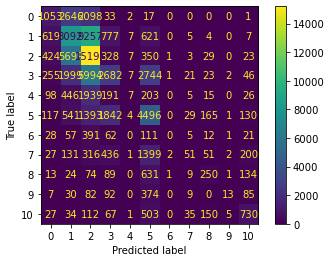

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

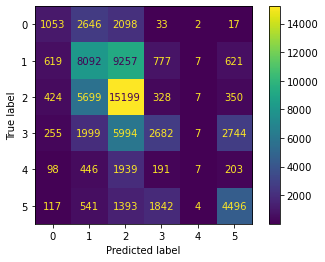

In [21]:
cm_reduced = cm[:6,:6]

cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

# Conclusion :

Similar Conclusion to Gradient BOOST

[Back to top](#Content:)


<a id='part11'></a>

## Part 11 - XGB BOOST Classifier


In [23]:
from xgboost import XGBClassifier

In [24]:
xgb = XGBClassifier()

In [25]:
xgb.fit(X_train, y_train)

/Users/baraa/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
y_pred = xgb.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
score = 1-np.mean(np.abs(y_test-y_pred))/K
print(f'Score : %.4f' % score)